<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/MNISTInpainting_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [94]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [95]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     - 11.2MB 1.6MB/s


In [0]:
import corner

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

In [98]:
generator_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path     = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path    = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
plot_path        = './gdrive/My Drive/MPM/modules/gauss3b/plots/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:
from tensorflow.contrib.opt import ScipyOptimizerInterface
from tensorflow.contrib.distributions import softplus_inverse

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [104]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.12
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)
nvp_prior     = tf.placeholder_with_default(True,shape=[])

# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
input_data    = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)
mymask        = tf.placeholder_with_default(np.ones((data_dim),dtype=int),shape=[data_dim])
x_corr        = tf.boolean_mask(input_data, mymask, axis=1)
sigma_masked  = tf.boolean_mask(sigma_corr, mymask, axis=1)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)
# ------- mean field VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')


kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
zz_               = approx_posterior_elbo.sample()
fwd_zz_           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass'], lambda: zz_)
elbo_liklogits    = tf.boolean_mask(tf.reshape(generator(fwd_zz_),[-1,data_dim,n_channels]),mymask,axis=1)
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

mu_elbo_              = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_elbo},as_dict=True)['fwd_pass'], lambda: mu_elbo)
mu_liklogits          = tf.boolean_mask(tf.reshape(generator(mu_elbo_),[-1,data_dim,n_channels]),mymask, axis=1)
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()

samples_post_elbo     = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
samples_post_elbo     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':samples_post_elbo},as_dict=True)['fwd_pass'], lambda: samples_post_elbo)
sample_elbo_liklogits = tf.boolean_mask(tf.reshape(generator(tf.reshape(samples_post_elbo,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels]),mymask, axis=2)
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()

# ------- mean field VI on corrupted data ---------------#

# ------- full rank VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo_full_rank"):
  mu_f_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size), dtype=np.float32), dtype=np.float32)
  sigma_f_elbo   = tf.Variable(np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32), dtype=tf.float32)

sigma_f_elbo_t = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_f_elbo), transform=tf.nn.softplus)

approx_posterior_f_elbo = tfd.MultivariateNormalTriL(loc=mu_f_elbo,scale_tril=sigma_f_elbo_t)


kl_divergence_f    = tfd.kl_divergence(approx_posterior_f_elbo, prior) 
zz_f               = approx_posterior_f_elbo.sample()
fwd_zz_f           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_f},as_dict=True)['fwd_pass'], lambda: zz_f)
elbo_liklogits_f   = tf.boolean_mask(tf.reshape(generator(fwd_zz_f),[-1,data_dim,n_channels]),mymask, axis=1)
corr_likelihood_f  = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits_f,scale_diag=sigma_corr))
elbo_f             = -tf.reduce_mean(corr_likelihood_f.log_prob(x_corr)- kl_divergence_f,axis=0)

opt_op_elbo_f      = optimizer.minimize(elbo_f,var_list=[mu_f_elbo,sigma_f_elbo])

# likelihood of posterior mean
mu_elbo_f_             = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_f_elbo},as_dict=True)['fwd_pass'], lambda: mu_f_elbo)
mu_f_liklogits         = tf.boolean_mask(tf.reshape(generator(mu_elbo_f_),[-1,data_dim,n_channels]),mymask, axis=1)
mean_corr_likelihood_f = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_f_liklogits,scale_diag=sigma_corr)).mean()
sample_post_elbo_f     = tf.reshape(approx_posterior_f_elbo.sample(sample_size_z),[-1,hidden_size])
sample_post_elbo_f     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':sample_post_elbo_f},as_dict=True)['fwd_pass'], lambda: sample_post_elbo_f)
sample_elbo_liklogits_f= tf.boolean_mask(tf.reshape(generator(tf.reshape(sample_post_elbo_f,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels]),mymask, axis=2)
sample_elbo_mean_f     = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits_f,scale_diag=sigma_corr)).mean()

# ------- full rank VI on corrupted data ---------------#





inverse_T            = tf.placeholder_with_default(1., shape=[])
### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)
MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

#### for naive recon and strating MAP finding at truth
def get_posterior(z_value):
  
  log_likelihood  = get_likelihood(z_value)[0]

  posterior_z     = prior.log_prob(z_value)+log_likelihood
  
  return posterior_z


def get_likelihood(z_value):
  
  fwd_z           = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z_value},as_dict=True)['fwd_pass']

  gen_z           = tf.boolean_mask(tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_z), lambda: generator(z_value)),[batch_size2,data_dim,n_channels]),mymask, axis=1)

  likeli_z        = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma_masked))
  
  likeli_mean     = likeli_z.mean()

  likeli_log_prob = likeli_z.log_prob(x_corr)*inverse_T
  
  return likeli_log_prob, likeli_mean

def get_minimizer_loss(pos):
  
  loss      = -tf.squeeze(get_posterior(pos))
  grad_loss = tf.gradients(loss,pos)[0]
  
  return loss, grad_loss
  
loss_MAP     = get_minimizer_loss(MAP)

opt_op_MAP   = optimizer.minimize(loss_MAP[0], var_list=[MAP])

lbfgs_results= tfp.optimizer.bfgs_minimize(get_minimizer_loss, initial_position=MAP_ini, tolerance=1e-8)


##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


# this is exact hessian computation 
hess             = tf.hessians(-get_posterior(MAP),MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

fwd_MAP          = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

genMAP           = tf.boolean_mask(tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,data_dim,n_channels]),mymask, axis=1)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_masked),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only the diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

log_det          = tf.linalg.logdet(approx_posterior_laplace.covariance())

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.boolean_mask(tf.reshape(generator(fwd_zs),[-1,784,n_channels]),mymask, axis=1)
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_masked))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())



# num_chains =20

# # def unnormalized_log_prob(x):
  
# #   fwd_x              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':x},as_dict=True)['fwd_pass']

# #   # option to use uncorrected latent space
# #   gen_x              = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_x), lambda: generator(x)),[num_chains,data_dim,n_channels])

# #   likeli_x           = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_x,scale_diag=sigma_masked))

# #   likeli_log_prob_x  = likeli_x.log_prob(x_corr)

# #   prior_x            = prior.log_prob(x)

# #   posterior_x        = prior_x+likeli_log_prob_x

# #   return posterior_x


# # #### ----- this is an hmc sampler------------#

# # # Create state to hold updated `step_size`.
# # step_size = tf.get_variable(
# #     name='step_size',
# #     initializer=np.ones((num_chains,hidden_size),dtype=np.float32)*1.,
# #     use_resource=True,  # For TFE compatibility.
# #     trainable=False)



# # ini_chain = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)
# # # Initialize the HMC transition kernel.
# # num_results      = int(2e4)
# # num_burnin_steps = int(2e3)

# # hmc = tfp.mcmc.HamiltonianMonteCarlo(
# #     target_log_prob_fn=unnormalized_log_prob,
# #     num_leapfrog_steps=3,
# #     step_size=step_size,
# #     step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
# #       num_adaptation_steps=int(num_burnin_steps * 0.8)))

# # # Run the chain (with burn-in).
# # hmc_samples, hmc_kernel_results = tfp.mcmc.sample_chain(
# #     num_results=num_results,
# #     num_steps_between_results=10,
# #     num_burnin_steps=num_burnin_steps,
# #     current_state=ini_chain,
# #     kernel=hmc)
# # #### ----- this is an hmc sampler------------#

# # #### ----- this is a a Random Walk Metropolis Hastings------------#

# # # Initial state of the chain
# # init_state = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)

# # # Run Random Walk Metropolis with normal proposal for `num_results`
# # # iterations for `num_chains` independent chains:
# # mcmc_samples, mcmc_stats = tfp.mcmc.sample_chain(
# #     num_results=num_results,
# #     current_state=init_state,
# #     kernel=tfp.mcmc.RandomWalkMetropolis(
# #         target_log_prob_fn=unnormalized_log_prob,
# #         seed=54,
# #         new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1,name=None)),
# #     num_burnin_steps=num_burnin_steps,
# #     num_steps_between_results=10,  # Thinning.
# #     parallel_iterations=1)


# # # # construct a GMM approximation from different minima
# num_comp = 2

# offset = tf.placeholder(shape=[], dtype=tf.float32)

# ini_val2    = np.ones((batch_size2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((batch_size2,num_comp,hidden_size)), dtype=np.float32)
#   sigma_gmm   = tf.Variable(tfd.fill_triangular(ini_val2))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
#   c_gmm       = tf.Variable(1., dtype=np.float32)
  
# sigma_gmmt    = tfd.matrix_diag_transform(sigma_gmm, transform=tf.nn.softplus)
# w_positive    = tf.math.softplus(w_gmm)
# # sum of w must be 1
# A             = -tf.math.log(tf.reduce_sum(w_positive))
# w_rescaled    = tf.squeeze(w_positive*tf.exp(A))


# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# mu_est        = tf.placeholder_with_default(tf.zeros([batch_size2,num_comp,hidden_size]),shape=[batch_size2,num_comp,hidden_size])
# sigma_est     = tf.placeholder_with_default(tf.ones([batch_size2,num_comp,hidden_size, hidden_size]),shape=[batch_size2,num_comp,hidden_size, hidden_size])
# w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_a      = tf.stop_gradient(w_gmm.assign(softplus_inverse(w_est)))
# update_b      = tf.stop_gradient(mu_gmm.assign(mu_est))
# update_c      = tf.stop_gradient(sigma_gmm.assign(tfd.matrix_diag_transform(sigma_est, transform=softplus_inverse)))
# update_d      = tf.stop_gradient(c_gmm.assign(A-tf.math.log(2.*np.pi)*hidden_size/2.+offset))


# gmm_sample_z  = tf.squeeze(gmm.sample(sample_size_z))
# gmm_fwd       = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample_z},as_dict=True)['fwd_pass'], lambda:gmm_sample_z)
# gmm_fwd       = tf.reshape(generator(gmm_fwd),[-1,data_dim,1])
# gmm_sample_x  = tfd.Independent(tfd.MultivariateNormalDiag(loc=gmm_fwd,scale_diag=sigma_masked)).mean()

# #### optimize on GMM using EL20

# gmm_sample    = tf.reshape(tf.identity(gmm.sample(sample_size_z)),[batch_size2*sample_size_z,hidden_size])
# fwd_sample    = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample},as_dict=True)['fwd_pass']

# # option to use uncorrected latent space
# gen_z         = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_sample), lambda: generator(gmm_sample)),[batch_size2*sample_size_z,data_dim,n_channels])

# likeli_z      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma_masked))

# likeli_log_prob_z = likeli_z.log_prob(x_corr)

# prior_z       = prior.log_prob(gmm_sample)

# posterior_z   = -(prior_z+likeli_log_prob_z)

# posterior_gmm = -gmm.log_prob(gmm_sample)

# grad_gmm      = tf.gather(tf.gradients(posterior_gmm,gmm_sample),0)

# grad_post     = tf.gather(tf.gradients(posterior_z,gmm_sample),0)

# gradgrad_gmm  = tf.reduce_sum(tf.gather(tf.hessians(grad_gmm,gmm_sample),0),axis=2)

# gradgrad_post = tf.reduce_sum(tf.gather(tf.hessians(grad_post,gmm_sample),0),axis=2)

# abs_diff      = posterior_gmm-posterior_z+c_gmm

# el2o_red      = tf.reduce_mean(tf.square(posterior_gmm-posterior_z+c_gmm))+tf.reduce_mean(tf.square(grad_post-grad_gmm))#+weight*tf.reduce_mean(tf.square(gradgrad_post-gradgrad_gmm))

# opt_op_el2o_red= optimizer.minimize(el2o_red,var_list=[mu_gmm, sigma_gmm,w_gmm, c_gmm])

# weight        = tf.placeholder_with_default(1.,shape=[])

# el2o          = tf.reduce_mean(tf.square(posterior_gmm-posterior_z+c_gmm))+tf.reduce_mean(tf.square(grad_post-grad_gmm))+weight*tf.reduce_mean(tf.square(gradgrad_post-gradgrad_gmm))

# opt_op_el2o   = optimizer.minimize(el2o,var_list=[mu_gmm, sigma_gmm,w_gmm, c_gmm])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:19.391264 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:19.441724 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:19.519533 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:20.179741 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:20.596823 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:20.672678 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:21.855619 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:21.947767 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:22.373024 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:22.472849 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:22.962927 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:23.069563 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:24.271317 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:24.398827 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:24.889806 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:25.017174 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:25.417745 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:25.565588 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:25.664660 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:27.388968 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:27.547594 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:27.666806 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:28.881656 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:29.062457 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:29.193494 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:30.480796 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:30.691196 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:30.842063 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:34.067443 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:34.317186 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:34.484936 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:35.845422 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:36.076639 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:36.257749 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:37.690827 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:37.950857 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:38.157109 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:39.858433 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:40.157663 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:40.374500 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:41.983100 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:42.272522 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:42.513545 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:44.356697 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:44.708863 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:44.979278 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:47.092714 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:47.467634 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:47.752501 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:51.486206 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:51.852049 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:52.171904 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:53.981700 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:54.377846 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:54.696760 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:56.363227 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:56.737369 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:57.073029 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:58.633973 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:59.019252 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:34:59.372402 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:35:01.943974 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:35:02.400447 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:35:02.800698 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:35:04.193666 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 22:35:04.642053 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**get histogramms of reconstruction error of uncorrupted data**

In [106]:
num_iter = len(x_test)//batch_size
print(num_iter)
max_recon=0.
min_recon=1.
max_input=0.
min_input=1.
for ii in range(num_iter):
  x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
  rec       = sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)})
  max_recon = max(max_recon,max(rec.flatten()))
  min_recon = min(min_recon,min(rec.flatten()))

print(max_recon,min_recon)
print(max_input,min_input)

156
1.7157391 -0.6785018
0.0 1.0


156
1.7157391 -0.6785018
0.0 1.0
0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


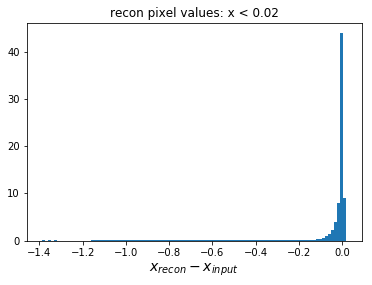

1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


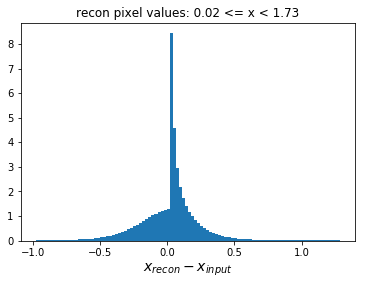

2
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


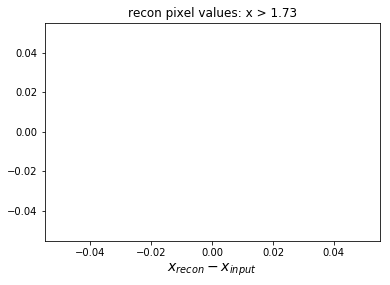

In [126]:
num_iter = len(x_test)//batch_size
print(num_iter)
max_recon=0.
min_recon=1.
max_input=0.
min_input=1.
for ii in range(num_iter):
  x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
  rec       = sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)})
  max_recon = max(max_recon,max(rec.flatten()))
  min_recon = min(min_recon,min(rec.flatten()))

print(max_recon,min_recon)
print(max_input,min_input)


#bins_recon  = np.linspace(0.01,1.01,11.)
bins_recon  = np.linspace(0.02,max_recon+0.01,2)

for jj in range(len(bins_recon)+1):
  print(jj)
  ordered_inp = []
  ordered_rec = []
  full_rec    = []
  full_inp    = []
  for ii in range(num_iter):
    if ii%10==0:
      print(ii)
    x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
    rec       = np.squeeze(sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)}))
    indices   = numpy.digitize(rec,bins_recon)
    ordered_rec.append(rec[np.where(indices==jj)].flatten())
  
    ordered_inp.append(x_input[np.where(indices==jj)].flatten())
    
    full_inp.append(x_input.flatten())
    full_rec.append(rec.flatten())

  rec_bin =np.asarray([item for sublist in ordered_rec for item in sublist])
  inp_bin =np.asarray([item for sublist in ordered_inp for item in sublist])
    
#   plt.figure()
#   plt.title('input pixel values: %.2f <= x <= %.2f'%(bins_recon[jj],bins_recon[jj+1]))
#   _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
#   plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
#   plt.savefig(plot_path+'input_bins_fine_binnum%d.png'%(jj+1),bbox_inches='tight',color='tomato')
#   plt.show()
  if jj is 0:
    plt.figure()
    plt.title('recon pixel values: x < %.2f'%(bins_recon[jj]))
    _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
    plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
    plt.savefig(plot_path+'recon_bins_coarse_binnum%d.png'%(jj),bbox_inches='tight',color='tomato')
    plt.show()
  elif jj is len(bins_recon):
    plt.figure()
    plt.title('recon pixel values: x > %.2f'%(bins_recon[jj-1]))
    _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
    plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
    plt.savefig(plot_path+'recon_bins_coarse_binnum%d.png'%(jj),bbox_inches='tight',color='tomato')
    plt.show()    
  else:   
    plt.figure()
    plt.title('recon pixel values: %.2f <= x < %.2f'%(bins_recon[jj-1],bins_recon[jj]))
    _=plt.hist(rec_bin-inp_bin,bins=100,density=True)
    plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
    plt.savefig(plot_path+'recon_bins_coarse_binnum%d.png'%(jj+1),bbox_inches='tight',color='tomato')
    plt.show()


0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
[0. 0. 0. ... 0. 0. 0.]
[ 1.3352823e-04 -8.1744147e-05 -8.4244493e-06 ...  1.4824371e-03
 -1.0297839e-05 -4.1344715e-04]
1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
[0. 0. 0. ... 0. 0. 0.]
[0.02577235 0.03597046 0.04120356 ... 0.04950745 0.06720827 0.04670155]
2
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
[]
[]
[0.035516664, 0.19848852, nan]


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

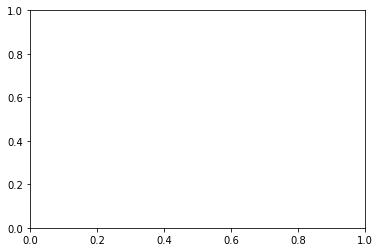

In [127]:
#bins_recon  = np.linspace(0.,1e-10,2)
L2s=[]

for jj in range(len(bins_recon)+1):
  print(jj)
  full_rec    = []
  full_inp    = []
  ordered_inp = []
  ordered_rec = []
  L2 = 0
  for ii in range(num_iter):
    
    if ii%10==0:
      print(ii)
    x_input   = x_test[ii*batch_size:(ii+1)*batch_size]
    rec       = np.squeeze(sess.run(recon, feed_dict={x_tr: np.expand_dims(x_input,-1)}))
    indices   = numpy.digitize(rec,bins_recon)

    ordered_rec.append(rec[np.where(indices==jj)].flatten())
  
    ordered_inp.append(x_input[np.where(indices==jj)].flatten())
    
    full_inp.append(x_input.flatten())
    full_rec.append(rec.flatten())

  rec_bin =np.asarray([item for sublist in ordered_rec for item in sublist])
  inp_bin =np.asarray([item for sublist in ordered_inp for item in sublist])
  print(inp_bin)
  print(rec_bin)
  L2=np.mean((rec_bin-inp_bin)**2)
  L2s.append(np.sqrt(L2))
  
print(L2s)
plt.figure()
plt.plot(np.diff(bins_recon)+bins_recon[0:-1],L2s,ls='',marker='o')
plt.xlabel('mean pixel values of reconstruction')
plt.ylabel('$\sqrt{E[(x_{recon}-x_{input})^2]}$', fontsize=14)
#plt.savefig(plot_path+'rms_difference_against_input_fine_bins.png',bbox_inches='tight')

plt.figure()
plt.plot(np.diff(bins_recon)+bins_recon[0:-1],L2s,ls='',marker='o')
plt.xlabel('mean pixel values of reconstruction')
plt.ylabel('$\sqrt{E[(x_{recon}-x_{input})^2]}$', fontsize=14)
#plt.savefig(plot_path+'rms_difference_against_input_fine_bins.png',bbox_inches='tight')

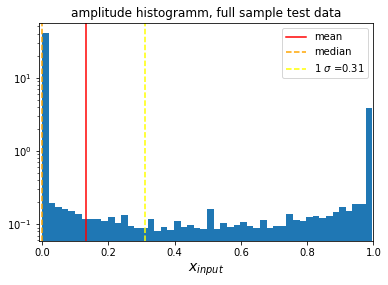

In [128]:
  diff=np.asarray(full_inp).flatten()
  plt.figure()
  plt.title('amplitude histogramm, full sample test data')
  _=plt.hist(diff,bins=50,density=True)
  plt.axvline(np.mean(diff),label='mean',color='red')
  plt.axvline(np.median(diff),label='median',color='orange',ls='--')
  plt.axvline(np.std(diff),label='1 $\sigma$ =%.2f'%np.std(diff),color='yellow',ls='--')
  plt.axvline(-np.std(diff),color='yellow',ls='--')
  plt.xlabel('$x_{input}$', fontsize=14)
  plt.xlim(-.01,1)
  plt.yscale('log')
  plt.legend()
  plt.savefig(plot_path+'input_histogramm.png',bbox_inches='tight')
  plt.show()

In [0]:
#   diff=np.asarray(full_rec).flatten()-np.asarray(full_inp).flatten()
#   plt.figure()
#   plt.title('full sample')
#   _=plt.hist(diff,bins=100,density=True)
#   plt.axvline(np.mean(diff),label='mean',color='red')
#   plt.axvline(np.median(diff),label='median',color='orange',ls='--')
#   plt.axvline(np.std(diff),label='1 $\sigma$ =%.2f'%np.std(diff),color='yellow',ls='--')
#   plt.axvline(-np.std(diff),color='yellow',ls='--')
#   plt.xlabel('$x_{recon}-x_{input}$', fontsize=14)
#   plt.xlim(-0.5,0.5)
#   plt.legend()
#   plt.savefig(plot_path+'full_sample_histogramm.png',bbox_inches='tight')
#   plt.show()

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

In [92]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
print(min(rec.flatten()))
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray'); colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('recon-truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0]-x_truth[i],(28,28)),cmap='gray'); colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray'); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

NameError: ignored

**Fit NVP to posterior for better samples**

In [0]:
# nvp_loss = []
# ii     = 0
# nepoch = 0
# learning_rate = 1e-3

In [91]:
(np.log(2*np.pi*0.12**2)/2.+0.5)*28*28

-549.8388023484081

In [0]:
# #train the nvp
# while nepoch<1000:
#   if (ii+1)*batch_size>len(x_train): 
#     np.random.shuffle(x_train)
#     ii=0
#     nepoch+=1
#     print('starting epoch', nepoch)
#   if nepoch>10:
#     learning_rate=1e-5
#   if nepoch>200:
#     learning_rate=1e-6
#   x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
#   _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
#   nvp_loss+=[ll]
#   if ii%500==0:
#     print(ll)
#   ii+=1

In [0]:
# plt.figure()
# plot(nvp_loss[::],label='nvp loss')
# legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0516 05:05:08.029361 140614245906304 saver.py:1483] Saver not created because there are no variables in the graph to restore


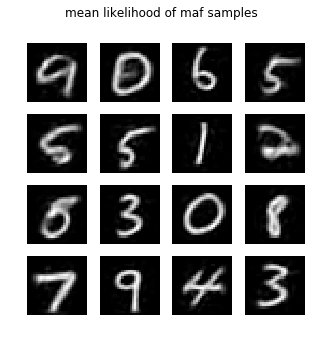

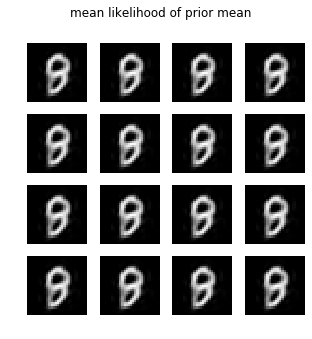

In [29]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [13]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 04:53:53.923635 139941427271552 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


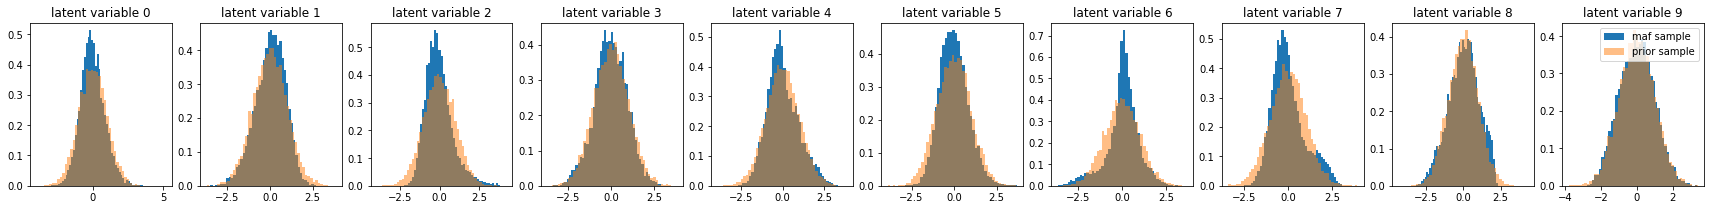

In [14]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

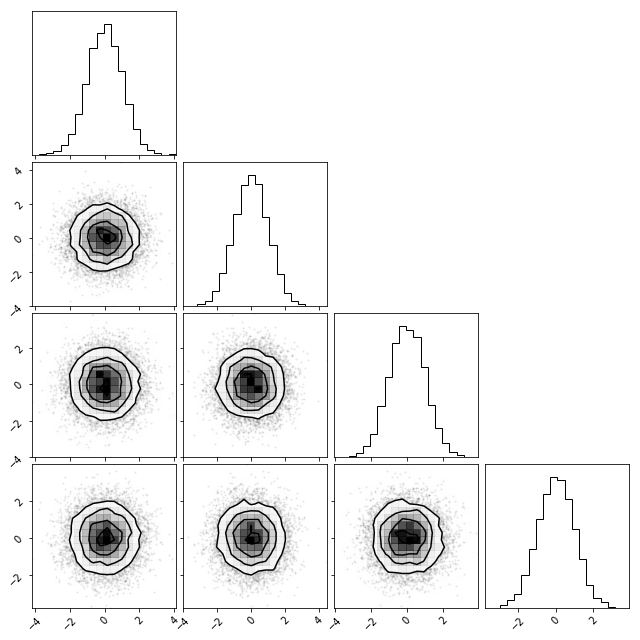

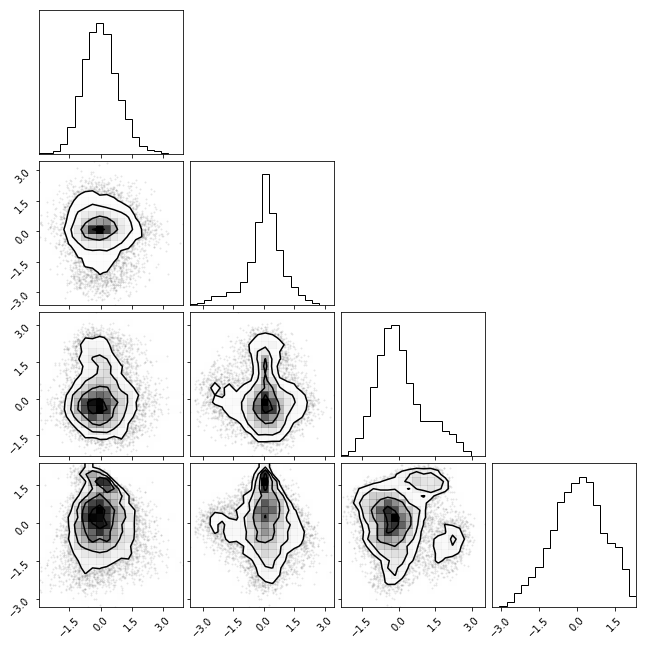

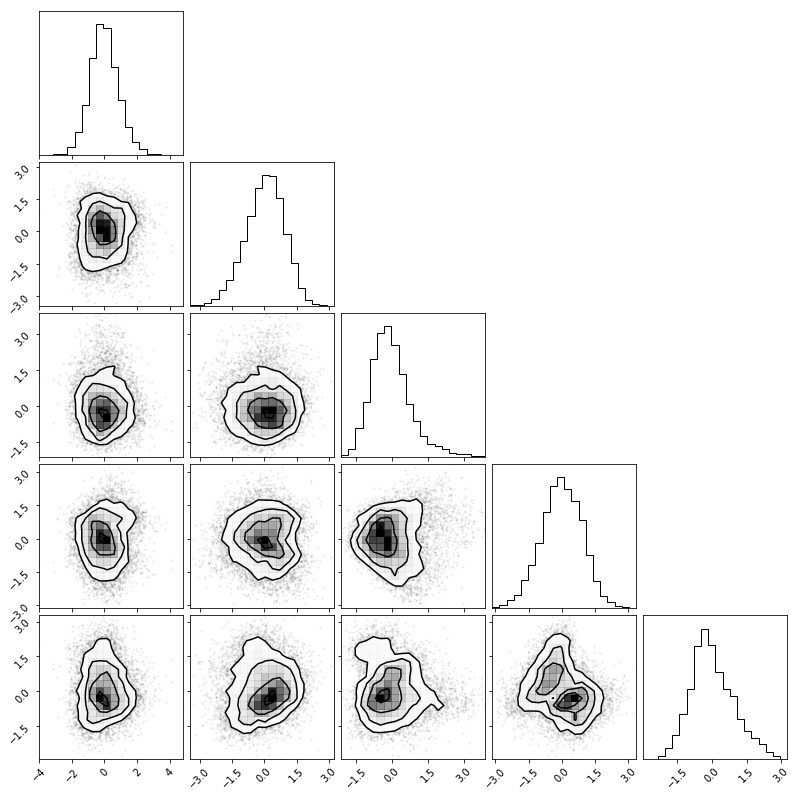

In [150]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

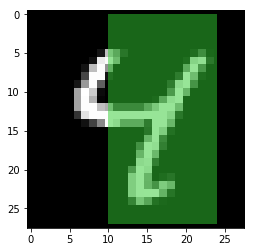

In [68]:
sigma_low = 0.07
sigma_high= 0.22
threshold = 0.02

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
minx = 10
maxx = 24
mask[0:28,minx:maxx]=0.
mask = mask.reshape((28*28))

sigma_new = np.ones(mask.shape)


x_true      = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
data        = np.expand_dims(masked_data,-1)


#signal dependent noise
sigma_new[np.where(x_true[0]<=threshold)]=sigma_low
sigma_new[np.where(x_true[0]>threshold)]=sigma_high

#should be masked anyways
sigma_new[np.where(mask==0)] = 1e4
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)


plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
x = np.arange(28)
plt.fill_between(x, 0, 27, where=[(x>=minx)*(x<=maxx)][0] ,facecolor='limegreen', alpha=0.5)
plt.show()


**find minima with nvp**

In [0]:
mini_ini=[]
np.random.seed(28)
for ii in range(20):
  if ii ==1:
      mini_ini+=[np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))+1e-8]
  elif ii==0:
      mini_ini+=[sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})]
  else:
      mini_ini+=[np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))]

In [0]:
maps ={}
minima={}
pos_defs={}
final_losses={}


l_minima            = []
map_minima          = []
pos_def             = []
for ii in range(0):
  posterior_corr_loss = []
  ini = mini_ini[ii]

  sess.run(MAP_reset,feed_dict={input_data:np.expand_dims(x,-1) , MAP_ini:ini, mymask:mask,sigma_corr:sigma_new})

  lrate=1e-1
  for jj in range(10000):
    inv_T= np.round(0.5*np.exp(-(1.-jj/10000)),decimals=1)
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, sigma_corr:sigma_new, lr: lrate, inverse_T:inv_T})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll, inv_T)
  lrate=1e-2
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for jj in range(4000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  ev= sess.run(eig1,feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new,true_hess:True})
  print(ev)
  if np.all(ev>0.):
    if ii is not 0:
      pos_def+=[ii]

  #plt.plot(posterior_corr_loss,label='data_loss')
  #plt.show()
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={input_data: data, sigma_corr:sigma_new})]
    

In [175]:
maps ={}
minima={}
pos_defs={}
final_losses={}

#for minimizer in ['lbfgs','lm','trf']:#,'annealing','adam']
l_minima            = []
map_minima          = []
pos_def             = []
for ii in range(20):
  posterior_corr_loss = []
  ini = mini_ini[ii]

  sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:ini, mymask:mask,sigma_corr:sigma_new})
  lrate=1e-1
  for jj in range(10000):
    if ii is not 0:
      inv_T= np.round(0.5*np.exp(-(1.-jj/10000)),decimals=1)
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new, lr: lrate, inverse_T:inv_T})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll, inv_T)
  lrate=1e-2
  for jj in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for jj in range(4000):
    _, ll = sess.run([opt_op_MAP,loss_MAP[0]],feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if jj%1000==0:
      print(ll)
  ev= sess.run(eig1,feed_dict={input_data: data, mymask:mask, sigma_corr:sigma_new,true_hess:True})
  print(ev)
  if np.all(ev>0.):
    if ii is not 0:
      pos_def+=[ii]

  #plt.plot(posterior_corr_loss,label='data_loss')
  #plt.show()
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={input_data: data, sigma_corr:sigma_new})]
    
#   maps[minimizer]                = map_minima
#   final_losses[minimizer]        = l_minima
#   pos_defs[minimizer]            = pos_def


-51.069263 0.2
-108.55693 0.2
-108.55613 0.2
-108.55536 0.2
-164.11316 0.3
-163.58298 0.3
-165.30661 0.3
-224.62598 0.4
-225.46063 0.4
-274.38126 0.5
-584.4708
-587.5533
-587.69025
-587.7194
-587.7024
-587.73236
-587.67334
-587.72107
-587.7229
-587.69244
switching to lr 0.001
-587.7325
-587.7365
-587.73694
-587.7383
[[3.6683565e-01 1.0961459e+00 3.3489769e+00 5.8259182e+00 1.6722414e+01
  3.5356201e+01 6.4647781e+01 4.5613907e+02 1.8305557e+03 3.2994117e+04]]
-86.76976 0.2
-78.71501 0.2
-79.02089 0.2
-78.77507 0.2
-134.17052 0.3
-134.32634 0.3
-133.3854 0.3
-183.22815 0.4
-183.21265 0.4
-232.70041 0.5
-480.39493
-480.9029
-480.90506
-480.90442
-480.89294
-480.90497
-480.90497
-480.90326
-480.90427
-480.90433
switching to lr 0.001
-480.90445
-480.90616
-480.90628
-480.9064
[[  0.74908      0.93773264   1.5567503    2.4430237    3.356111
    5.5850296   40.72852     72.91578    159.56564    455.28204   ]]
463.04715 0.2
-101.39496 0.2
-103.96915 0.2
-105.93183 0.2
-166.29343 0.3
-169.053 

In [163]:
print(pos_def)

[1, 2, 3, 5, 6, 8, 9]


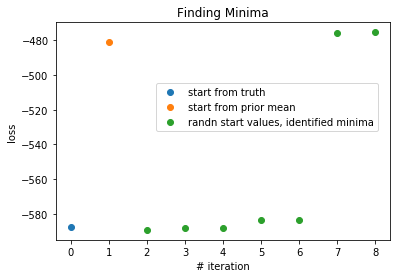

In [70]:
# print(pos_def)
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)
#l_minima_pos_def   = l_minima[pos_def]
#map_minima_pos_def = map_minima[pos_def]
plt.figure()
plt.title('Finding Minima')
plt.plot(0,l_minima[0],ls='',marker='o',label='start from truth')
plt.plot(1,l_minima[1],ls='',marker='o',label='start from prior mean')
plt.plot(np.arange(len(map_minima_pos_def))+2,l_minima_pos_def,ls='',marker='o', label='randn start values, identified minima')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.legend(loc=(0.3,0.5))
plt.savefig(plot_path+'minimzation_results_xmin%d_xmax%d_masked_and_new_sigmas.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
import pickle
try:
  l_minima,map_minima,l_minima_pos_def,map_minima_pos_def = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d_new_sigma_masked.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima,map_minima,l_minima_pos_def,map_minima_pos_def],open(minima_path+'nvp_minima_xmin%d_xmax%d_new_sigma_masked.pkl'%(minx,maxx),'wb'))
  
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

In [32]:
print(l_minima_pos_def[0])
_ = sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:map_minima_pos_def[0][0], sigma_corr:sigma_new})
  #get mean without mask
mean_at_map = sess.run(get_likelihood(MAP)[1],feed_dict={input_data: data, sigma_corr:sigma_new})
np.sum((np.squeeze(data)[np.where(mask==1)]-np.squeeze(mean_at_map)[np.where(mask==1)])**2/np.squeeze(sigma_new)[np.where(mask==1)]**2)

-589.29346
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 16:14:56.577982 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 16:14:57.139976 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 16:14:57.623676 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


87.56951198851603

In [29]:
print(np.sum((np.squeeze(data)[np.where(x_true[0]>0.02)]-np.squeeze(mean_at_map)[np.where(x_true[0]>0.02)])**2/np.squeeze(sigma_new)[np.where(x_true[0]>0.02)]**2))
print(len(np.where(x_true[0][np.where(mask==1)]>0.02)[0]))

38.44541607179685
31


In [30]:
print(np.sum((np.squeeze(data)[np.where(x_true[0]<=0.02)]-np.squeeze(mean_at_map)[np.where(x_true[0]<=0.02)])**2/np.squeeze(sigma_new)[np.where(x_true[0]<=0.02)]**2))
print(len(np.where(x_true[0][np.where(mask==1)]<=0.02)[0]))

49.12409648071609
361


**get covariances around minima**

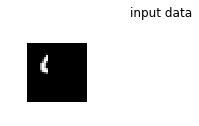

-589.29346
result 0
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 21:06:53.596697 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 21:06:54.156465 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 21:06:54.694745 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 21:07:02.916154 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 21:07:03.482411 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0520 21:07:03.988049 140523039504256 saver.py:1483] Saver not created because there are no variables in the graph to restore


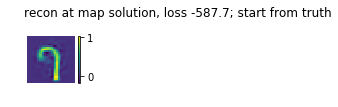

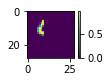

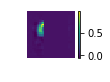

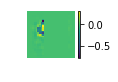

covariances


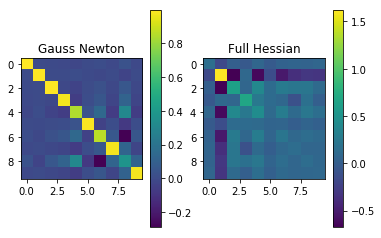

hessians


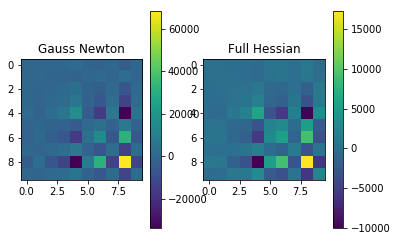

eigenvalues before and after inverse, full hessian
[array([[3.6683565e-01, 1.0961459e+00, 3.3489769e+00, 5.8259182e+00,
        1.6722414e+01, 3.5356201e+01, 6.4647781e+01, 4.5613907e+02,
        1.8305557e+03, 3.2994117e+04]], dtype=float32), array([[3.03084311e-05, 5.46282125e-04, 2.19231766e-03, 1.54682457e-02,
        2.82836952e-02, 5.97957093e-02, 1.71650335e-01, 2.98575114e-01,
        9.11910061e-01, 2.72475837e+00]])]
88.34204982947858
654.1300289553546
534.506769269459
119.62326014479298
344.87132744621215
115.39107206704624
229.48025562836375
851.9571985996346
724.2720428131698
127.6851563565831
1002.6102529664354
893.0702185307381
109.540035052271
92.28585872823868
38.89800614391575
53.387852933210574
2102.6039799342702
1956.8833991526114
145.72058130766496
156.3505335358098
95.36865360022955
60.98188034392922
612.1014608577858
505.33251790876676
106.76894339191924
1413.9841402746672
1282.9055639385024
131.07857690898092
95.30704204008957
57.52643158857505
37.78061079983769

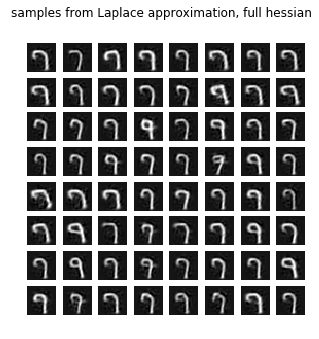

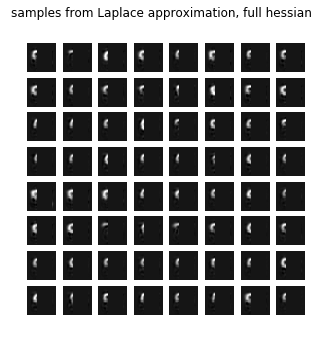

In [86]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis = [] 

order      = np.argsort(l_minima_pos_def)
results    = np.concatenate((np.expand_dims(map_minima[0],0),map_minima_pos_def[order]), axis=0)
l_results  = np.concatenate((np.expand_dims(l_minima[0],0),l_minima_pos_def[order]), axis=0)
print(l_results[1])
# go through minima
for ii,ini_ in enumerate(results[0:2]):
  print('result %d'%ii)
  
  _ = sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  #get mean without mask
  mean_at_map = sess.run(get_likelihood(MAP)[1],feed_dict={input_data: data, sigma_corr:sigma_new})
  
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={input_data: data, sigma_corr:sigma_new,mymask:mask, MAP_ini:ini_[0]})
  
  map_likeli, _ = sess.run(get_likelihood(MAP),feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
  map_prior     = sess.run(prior.log_prob(MAP),feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new})
  
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_results[ii])
  else:
    suptitle('%d, recon at map solution, loss %.1f'%(ii,l_results[ii]))
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)))
      plt.colorbar()
      axis('off')
  plt.show()
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(data[i,:],(28,28)))
      plt.colorbar()
  plt.show()
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)))
      plt.colorbar()
      axis('off')    
  plt.show()
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape((mean_at_map[i,:,0]-data[0,:,0])*mask,(28,28)))
      plt.colorbar()
      axis('off')
  plt.show()

#   # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})]
  

  
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True}))

  _ = sess.run(update3,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})
  l_samples = sess.run(lap_mean,feed_dict={input_data: data, sigma_corr:sigma_new, true_hess:True})
  print(np.sum((np.squeeze(data)[np.where(mask==1)]-np.squeeze(mean_at_map)[np.where(mask==1)])**2/np.squeeze(sigma_new)[np.where(mask==1)]**2))
  for nn in range(len(l_samples)):
    print(np.sum((np.squeeze(data)[np.where(mask==1)]-np.squeeze(l_samples[nn])[np.where(mask==1)])**2/np.squeeze(sigma_new)[np.where(mask==1)]**2),np.sum((np.squeeze(data)[x_true[0]<=0.02]-np.squeeze(l_samples[nn])[x_true[0]<=0.02])**2/np.squeeze(sigma_new)[x_true[0]<=0.02]**2),np.sum((np.squeeze(data)[x_true[0]>0.02]-np.squeeze(l_samples[nn])[x_true[0]>0.02])**2/np.squeeze(sigma_new)[x_true[0]>0.02]**2))
  figure(figsize=(5,5))
  suptitle('samples from Laplace approximation, full hessian')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=-0.1,vmax=1.1)
      axis('off')
  plt.show()
  figure(figsize=(5,5))
  suptitle('samples from Laplace approximation, full hessian')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0]*mask,(28,28)),cmap='gray',vmin=-0.1,vmax=1.1)
      axis('off')
  plt.show()

In [114]:
print(np.sum(np.log((sigma_new))))
print(data_dim/2*np.log(2*np.pi))

1948.1668134337922
720.4478100324634


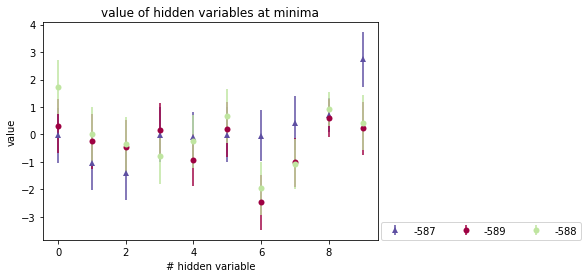

In [26]:
# check if minima are distinct
order              = np.argsort(l_minima_pos_def)
map_minima_pos_def = np.asarray(map_minima_pos_def[order])
l_minima_pos_def   = np.asarray(l_minima_pos_def[order])
varis              = np.asarray(varis)

colors = matplotlib.colors.Normalize(vmin=min(l_results[0:3]), vmax=max(l_results[0:3]))
cmap   = matplotlib.cm.get_cmap('Spectral')

plt.title('value of hidden variables at minima')
for ii in range(len(results)-5):
  yerr_= np.sqrt(varis[ii,0])
  if ii ==0:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
  else:
    plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_xmin%d_xmax%d_noannealing.png'%(minx,maxx),bbox_inches='tight')
plt.show()


# plt.title('value of hidden variables at minima')
# for ii in range(len(results[0:3])):
#   yerr_= np.sqrt(varis[ii,0])
#   if ii ==0:
#     plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='^',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
#   else:
#     plt.errorbar(np.arange(hidden_size),np.squeeze(results[ii]), marker='o',ls='', c=cmap(colors(l_results[ii])), mew=0, yerr=yerr_, label ='%d'%l_results[ii])
# plt.legend(ncol=4, loc=(1.01,0))
# plt.xlabel('# hidden variable')
# plt.ylabel('value')
# plt.savefig(plot_path+'minima_xmin%d_xmax%d_only_two.png'%(minx,maxx),bbox_inches='tight')
# plt.show()

**explore posterior around minima**

[[[ 0.30157056 -0.25725162 -0.46559805  0.16115157 -0.93112975
    0.18002118 -2.4809823  -1.0089093   0.5968026   0.22005923]]] -589.29346


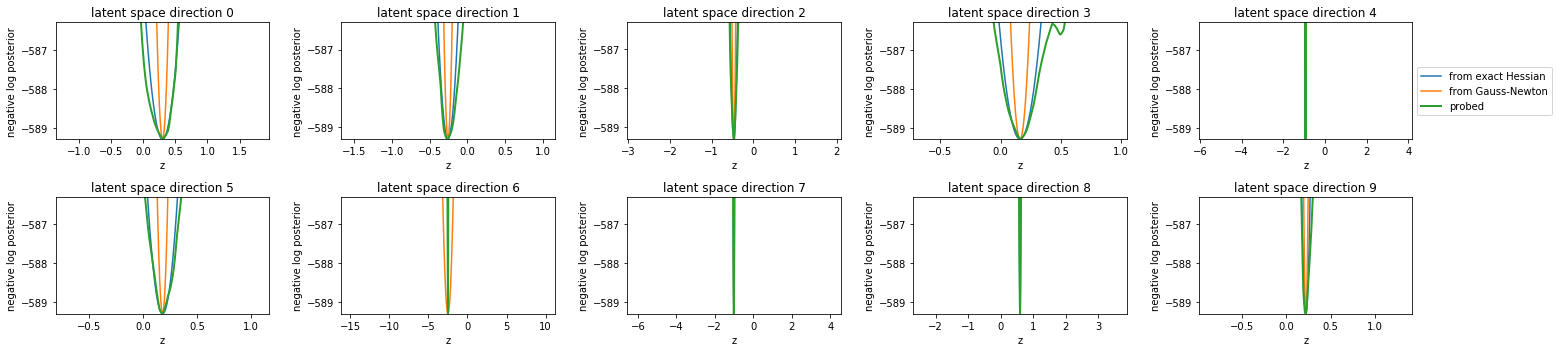

[[[ 1.7251042   0.0068636  -0.36372107 -0.79944927 -0.24793486
    0.6583278  -1.9627826  -1.0776503   0.9193531   0.42348152]]] -588.2544


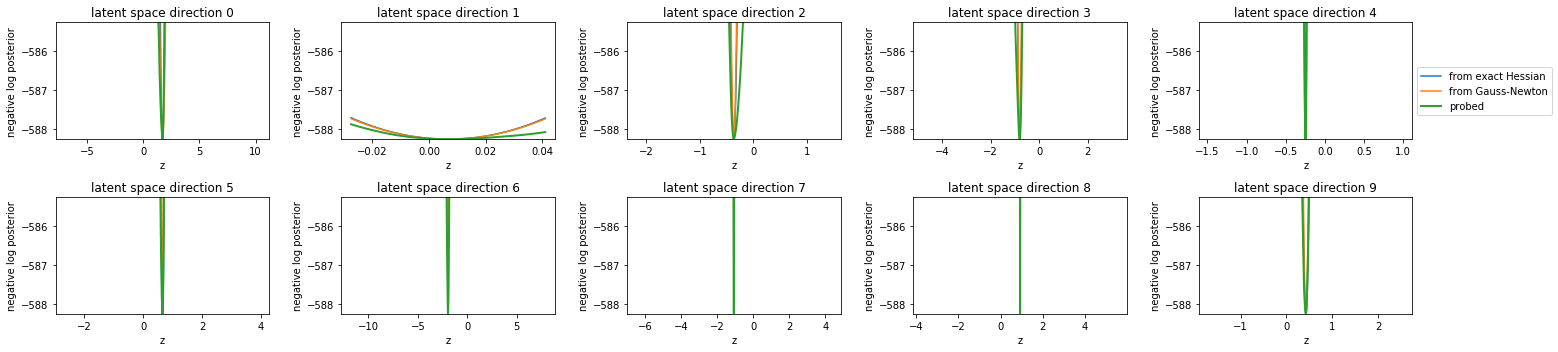

In [74]:
order     = np.argsort(l_minima_pos_def)[0:2]

# testing Hessian
for ii,ini_ in enumerate(map_minima_pos_def[order]):
  print(ini_, l_minima_pos_def[order][ii])
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={input_data: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={input_data: data,mymask:mask, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(loss_MAP[0],feed_dict={input_data: data,mymask:mask, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B    = measured_hessian[0,nn,nn]
    GN   = GN_hessian[0,nn,nn]
#     VIm  = np.linalg.inv(VI_cov)[0,nn,nn]

#     z_VI  = (0.001*(np.arange(1001)-501))*VI_mean[0,nn]
    
#     VImf  = np.linalg.inv(VI_f_cov)[0,nn,nn]

#     z_VIf = (0.001*(np.arange(1001)-501))*VI_f_mean[0,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(1001):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-501))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={input_data: data,mymask:mask, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(loss_MAP[0],feed_dict={input_data: data,mymask:mask, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(ll)
     

    

    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(1001)-501))*ini_[0][:,nn],ll0+B*((0.01*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from exact Hessian')
    #plt.plot(z_VI+VI_mean[0,nn],-ll0+VIm*z_VI**2,label='from mean field VI', color='tomato')
    #plt.plot(z_VIf+VI_f_mean[0,nn],-ll0+VImf*z_VIf**2,label='from full rank VI', color='darkblue')
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(1001)-501))*ini_[0][:,nn],ll0+GN*((0.01*(np.arange(1001)-501))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    #print(losses)
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(1001)-501))*ini_[0][:,nn],losses,label='probed', lw=2)
    
    
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.ylim(min(losses),min(losses)+3)
#     if nn in [0,1]:
#    plt.xlim(ini_[0][:,nn]-0.02, ini_[0][:,nn]+0.02)
#     elif nn in [2,3,4,5,6,9]:
#       plt.xlim(ini_[0][:,nn]-0.1, ini_[0][:,nn]+0.1)
#     elif nn in [7,8]:
#       plt.xlim(ini_[0][:,nn]-0.05, ini_[0][:,nn]+0.05)
  plt.tight_layout()
  plt.legend(loc=(1.02,1.7))
  
  
  
  plt.savefig(plot_path+'probing_posterior_xmin%d_xmax%d_newlikelihood_loss%d_zoomout.png'%(minx,maxx,-ll0),bbox_inches='tight')
  plt.show()


**Build Gaussian Mixture Model**

In [204]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]

offset_ = min(l_results) #for numerical stability
order   = np.append(np.argsort(l_minima_pos_def)[0],np.argsort(l_minima_pos_def)[1])#np.argsort(l_minima_pos_def)
mus     = map_minima_pos_def[order]

# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  sess.run(MAP_reset,feed_dict={input_data: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})
  mu_+=[sess.run(update2,feed_dict={input_data: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})]
  sigma_+=[sess.run(update3,feed_dict={input_data: data, sigma_corr:sigma_new,MAP_ini:mus[ii][0],true_hess:True})]
  

  logdet_ = sess.run(log_det,feed_dict={input_data: data, sigma_corr:sigma_new,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={input_data: data, sigma_corr:sigma_new})
  print(logprob)
  w_tilde+=[np.exp(0.5*logdet_+logprob+offset_)]

mu_    = np.reshape(np.asarray(mu_),[1,num_comp,hidden_size])
sigma_ = np.reshape(np.asarray(sigma_),[1,num_comp,hidden_size,hidden_size])

w_tilde= np.squeeze(np.asarray(w_tilde))


#before =sess.run(sigma_gmmt,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde })
_=sess.run(update_a,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
_=sess.run(update_b,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
_=sess.run(update_c,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
_=sess.run(update_d,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })

ws= sess.run(w_rescaled,feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
print(ws,np.sum(ws))
cc, qq, pp = sess.run([c_gmm, gmm.log_prob(mus[-1]),posterior_MAP],feed_dict={input_data: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w_tilde, offset:offset_ })
print('this should be zero:', cc-qq+pp)

[-2610.098]
[-2614.1653]
[0.9949962  0.00500302] 0.9999992
this should be zero: [[0.]]


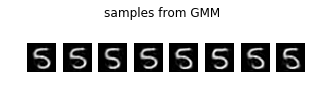

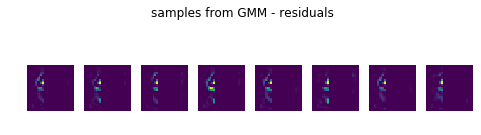

18.280572964497583


In [205]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={input_data: data, sigma_corr:sigma_new, offset:offset_})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d_annealing.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d_annealing.png'%(minx,maxx),bbox_inches='tight')
plt.show()

print(np.sum((gmm_samples[:,:,0]*mask-data[0,:,0]*mask)**2))

In [0]:
losses=[]

In [210]:
weight_=0.
for ii in range(1000):
  _, ll, mm, ww, cc, pp, gg, diff = sess.run([opt_op_el2o_red,el2o_red, mu_gmm,w_rescaled, c_gmm, posterior_gmm,posterior_z, abs_diff],feed_dict={input_data: data, sigma_corr:sigma_new, lr:1e-3, offset:offset_})
  losses.append(ll)
  if ii%200==0:
    print(ll,ww,sum(ww),cc,np.mean(pp), np.mean(gg), np.mean(diff))

6560.918 [0.9984563  0.00154455] 1.0000008 2624.7761 -9.272356 2629.4438 -13.940247
2877.9128 [0.99847347 0.00152585] 0.99999934 2625.2754 -10.896157 2625.5977 -11.218567
1611.0448 [9.9933654e-01 6.6433073e-04] 1.0000008 2625.7976 -9.672686 2626.9287 -10.803955
3584.5308 [9.995881e-01 4.128087e-04] 1.0000008 2626.233 -9.167431 2624.0593 -6.993805
1211.3887 [9.9962234e-01 3.7815617e-04] 1.0000005 2626.6116 -10.266684 2621.109 -4.7640076


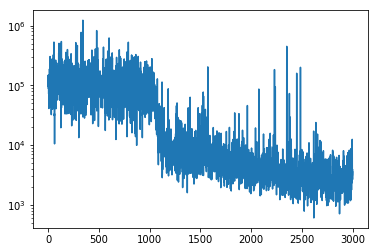

In [211]:
plt.plot(losses)
plt.yscale('log')

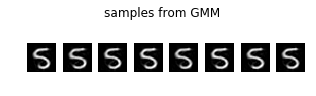

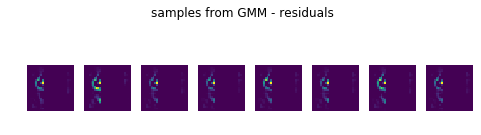

13.229199499620915


In [212]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={input_data: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

print(np.sum((gmm_samples[:,:,0]*mask-data[0,:,0]*mask)**2))

In [0]:
losses2=[]

In [216]:
weight_=1
for ii in range(20):
  _, ll, mm, ww, cc, pp, gg, diff = sess.run([opt_op_el2o,el2o, mu_gmm,w_rescaled, c_gmm, posterior_gmm,posterior_z, abs_diff],feed_dict={input_data: data, sigma_corr:sigma_new, lr:1e-4, offset:offset_, weight:weight_})
  losses2.append(ll)
  if ii%1==0:
    print(ll,ww,sum(ww),cc,np.mean(pp), np.mean(gg), np.mean(diff))

2461610.5 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.823833 2619.0522 -2.4927979
4555448.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.97097 2624.3774 -7.9654236
3073071.8 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.041865 2622.8198 -5.4785156
2463527.2 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.558861 2621.8657 -5.041626
3312580.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -12.321661 2620.3154 -5.2538757
3679113.8 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -9.863888 2619.5017 -1.982605
2329587.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.721672 2622.0488 -5.3873596
3539965.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -9.561429 2624.8755 -7.0538635
2521842.2 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -9.931238 2623.4387 -5.9868774
6635239.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.024919 2617.9363 -0.57818604
3825683.0 [9.9962044e-01 3.7881816e-04] 0.9999993 2627.383 -10.94418 2623.438 -6.999176
2541821

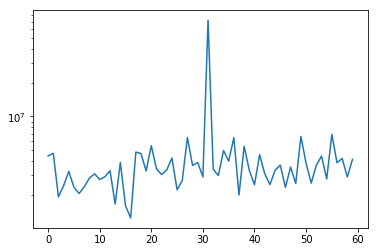

In [217]:
plt.plot(losses2)
plt.yscale('log')

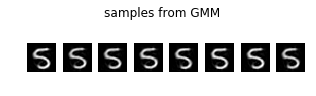

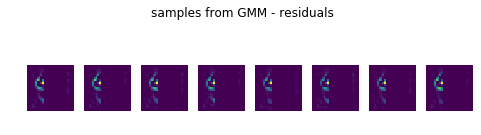

12.743787475849027


In [218]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={input_data: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(8,8))
suptitle('samples from GMM - residuals')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape((gmm_samples[i,:,0]-data[0,:,0])*mask,(28,28)),vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

print(np.sum((gmm_samples[:,:,0]*mask-data[0,:,0]*mask)**2))